In [1]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from jre_utils.datapath import model_ready_data_paths

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay, r2_score

from jre_utils.datapath import WEIGHTS_DIRECTORY_PATH

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
asset_type = "building"

metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key = "median"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"
upcoming_metric = "upcoming_" + metric
upcoming_metric_pct_chg = "upcoming_" + metric_pct_chg
normalized_upcoming_metric_pct_chg = "normalized_" + "upcoming_" + metric_pct_chg

In [3]:
dataset_key = "plps"
model_ready_data_path = model_ready_data_paths[f"xgb_{dataset_key}_{metric_key}"]

df = pd.read_csv(model_ready_data_path)
df[normalized_upcoming_metric_pct_chg] = df.groupby("year")[
    upcoming_metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

In [4]:
# y_columns = [upcoming_metric_pct_chg]
y_columns = [normalized_upcoming_metric_pct_chg]

X_categorical_columns = ["area_code", "area"]

X_basic_columns = [
    "year",
    "population",
    "count",
    "taxable_income_per_taxpayer",
    "taxable_income_per_taxpayer_growth",
    # "total_tax",
    "migrations_is_available",
    "taxable_income_is_available",
    # "total_tax_is_available",
    "dwellings_is_available",
]

X_engineering_columns = [
    "net_migration_ratio",
    "taxable_income_growth",
    "new_dwellings_ratio",
    # "total_tax_growth",
    metric_pct_chg,
]

X_engineered_columns = [
    "net_migration_ratio_ma3",
    "net_migration_ratio_cumu3",
    "net_migration_ratio_lag1",
    "taxable_income_growth_ma3",
    "taxable_income_growth_cumu3",
    "taxable_income_growth_lag1",
    "new_dwellings_ratio_ma3",
    "new_dwellings_ratio_cumu3",
    "new_dwellings_ratio_lag1",
    # "total_tax_growth_ma3",
    # "total_tax_growth_cumu3",
    # "total_tax_growth_lag1",
    "unit_price_median_pct_chg_ma3",
    "unit_price_median_pct_chg_cumu3",
    "unit_price_median_pct_chg_lag1",
]

X_columns = (
    X_categorical_columns
    + X_basic_columns
    + X_engineering_columns
    + X_engineered_columns
)

In [5]:
divide_year = 2020 # test_years = [2021]
train_df = df[df["year"] <= divide_year]
test_df = df[df["year"] > divide_year]

drop_columns = ["year", "area_code", "area"]
X_train_df, X_test_df = train_df[X_columns].drop(columns=drop_columns), test_df[X_columns].drop(columns=drop_columns)
y_train_df, y_test_df = train_df[y_columns], test_df[y_columns]

In [6]:
test_df

,area_code,area,year,population,count,total_traded_area,taxable_income_per_taxpayer,taxable_income_per_taxpayer_growth,total_tax,migrations_is_available,taxable_income_is_available,total_tax_is_available,dwellings_is_available,net_migration_ratio,taxable_income_growth,new_dwellings_ratio,total_tax_growth,unit_price_median_pct_chg,upcoming_unit_price_median_pct_chg,multiplier,net_migration_ratio_ma3,net_migration_ratio_cumu3,net_migration_ratio_lag1,taxable_income_growth_ma3,taxable_income_growth_cumu3,taxable_income_growth_lag1,new_dwellings_ratio_ma3,new_dwellings_ratio_cumu3,new_dwellings_ratio_lag1,total_tax_growth_ma3,total_tax_growth_cumu3,total_tax_growth_lag1,unit_price_median_pct_chg_ma3,unit_price_median_pct_chg_cumu3,unit_price_median_pct_chg_lag1,normalized_upcoming_unit_price_median_pct_chg
22,23441,Aichi-ken Agui-cho,2021,28421.0,5.0,1685.0,3460.559927,0.010694,4072735.0,1,1,1,0,0.001337,0.000999,0.000000,-0.035334,-0.005319,0.009358,0.994681,-0.001055,0.996834,-0.001585,0.006591,1.019833,0.002647,0.000000,1.000000,0.000000,-0.015361,0.954324,-0.005192,0.059024,1.176101,0.182390,0.594111
23,23441,Aichi-ken Agui-cho,2022,28421.0,5.0,1685.0,0.000000,0.000000,4187958.0,1,0,1,0,0.000000,0.000000,0.000000,0.028291,0.009358,0.013245,1.009358,-0.000083,0.999749,0.001337,0.001215,1.003649,0.000999,0.000000,1.000000,0.000000,-0.004078,0.986807,-0.035334,0.062143,1.187107,-0.005319,0.553068
39,23232,Aichi-ken Aisai-shi,2021,60698.0,8.0,3203.0,3143.470864,-0.002639,7662720.0,1,1,1,1,-0.002158,0.000115,0.013938,-0.010846,-0.007317,-0.003276,0.992683,-0.000807,0.997579,0.000099,0.007076,1.018741,-0.040435,0.012997,1.039496,0.010437,-0.001756,0.994296,-0.016919,0.016303,1.047170,0.074236,0.080049
40,23232,Aichi-ken Aisai-shi,2022,60666.0,8.0,2523.0,0.000000,0.000000,7876628.0,1,0,1,0,-0.000527,0.000000,0.000000,0.027915,-0.003276,-0.003287,0.996724,-0.000862,0.997414,-0.002158,-0.013440,0.959675,0.000115,0.008125,1.024521,0.013938,0.000050,0.999563,-0.010846,0.021214,1.062882,-0.007317,-0.048717
51,23237,Aichi-ken Ama-shi,2021,86232.0,10.0,3046.0,3318.685761,0.005373,10929885.0,1,1,1,1,0.001229,0.011146,0.014707,-0.027785,-0.001332,0.000000,0.998668,0.000763,1.002289,-0.000952,0.021078,1.064474,0.031202,0.014605,1.044455,0.013064,-0.001746,0.994240,0.015594,-0.001109,0.996676,-0.001995,0.213342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39358,19212,Yamanashi-ken Uenohara-shi,2022,22525.0,8.0,12874.0,0.000000,0.000000,3132993.0,1,0,1,0,-0.005194,0.000000,0.000000,0.001070,-0.011261,-0.009112,0.988739,-0.004555,0.986387,-0.001192,-0.009829,0.970541,-0.000960,0.003114,1.009363,0.004741,-0.007558,0.977422,-0.007267,-0.023144,0.932059,-0.028446,-0.260751
39380,19425,Yamanashi-ken Yamanakako-mura,2021,5171.0,4.0,4087.0,3234.950203,0.019162,2577395.0,1,1,1,0,-0.001547,0.010219,0.000000,0.044165,0.006969,0.013841,1.006969,-0.000311,0.999028,0.006565,-0.005582,0.980617,-0.063679,0.000000,1.000000,0.000000,-0.126013,0.639187,-0.110067,0.004662,1.014035,0.000000,0.776497
39381,19425,Yamanashi-ken Yamanakako-mura,2022,5151.0,4.0,4087.0,0.000000,0.000000,3246473.0,1,0,1,0,-0.003883,0.000000,0.000000,0.259595,0.013841,0.013652,1.013841,0.000378,1.001106,-0.001547,-0.017820,0.945889,0.010219,0.000000,1.000000,0.000000,0.064564,1.170462,0.044165,0.006936,1.020906,0.006969,0.567878
39402,19205,Yamanashi-ken Yamanashi-shi,2021,33357.0,11.0,15726.0,2956.122862,0.029921,4065382.0,1,1,1,1,-0.002338,0.022114,0.011216,-0.013078,-0.025974,0.000000,0.974026,-0.002469,0.992610,-0.000927,0.015507,1.047160,0.004950,0.009261,1.028039,0.008121,0.005935,1.017593,0.008865,-0.029303,0.914634,-0.031447,0.213342


In [7]:
X_train_df.shape, y_train_df.shape

((36004, 23), (36004, 1))

<Axes: ylabel='Frequency'>

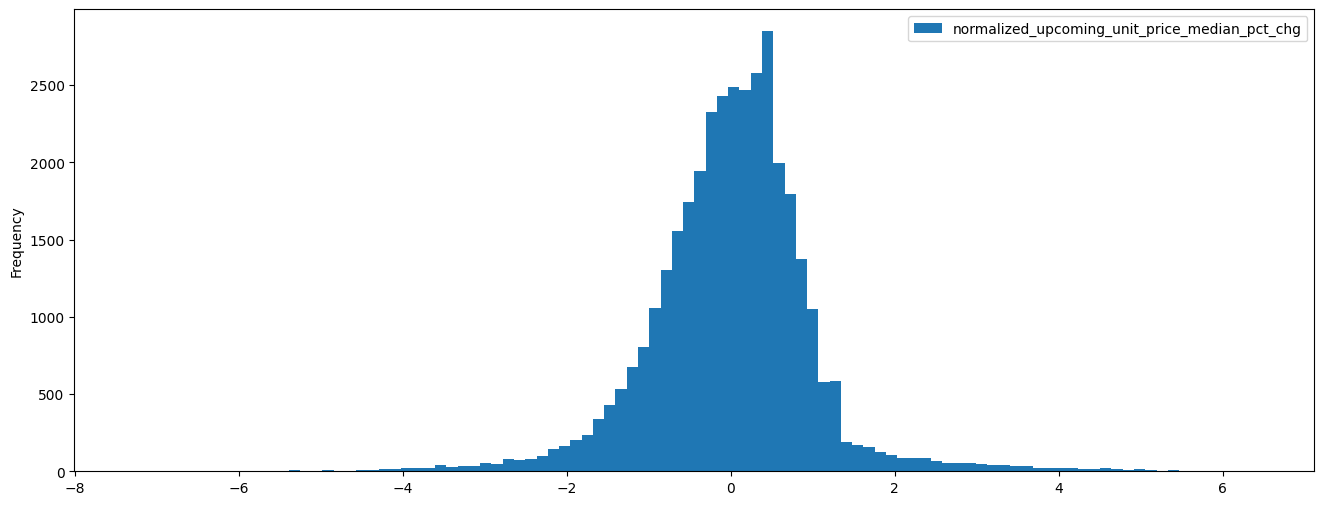

In [8]:
y_train_df.plot.hist(bins=100, figsize=(16, 6))

In [9]:
# xgb_regressor = XGBRegressor(tree_method="gpu_hist", gpu_id=0, predictor="gpu_predictor")
xgb_regressor = XGBRegressor(
    tree_method="hist", early_stopping_rounds=4, enable_categorical=True
)
# xgb_regressor = XGBRegressor(
#     tree_method="hist", enable_categorical=True
# )
xgb_regressor.fit(X_train_df, y_train_df, eval_set=[(X_test_df, y_test_df)])

y_train_pred = xgb_regressor.predict(X_train_df)
y_test_pred = xgb_regressor.predict(X_test_df)

print()
print(f"Train RMSE: {mean_squared_error(y_train_df, y_train_pred, squared=False):.4f}")
print(f"Test RMSE: {mean_squared_error(y_test_df, y_test_pred, squared=False):.4f}")

print(f"Train R2: {r2_score(y_train_df.values.squeeze(), y_train_pred):.4f}")
print(f"Test R2: {r2_score(y_test_df.values.squeeze(), y_test_pred):.4f}")

[0]	validation_0-rmse:0.90496
[1]	validation_0-rmse:0.84833
[2]	validation_0-rmse:0.81258
[3]	validation_0-rmse:0.78052
[4]	validation_0-rmse:0.76607
[5]	validation_0-rmse:0.75860
[6]	validation_0-rmse:0.74388
[7]	validation_0-rmse:0.73958
[8]	validation_0-rmse:0.73594
[9]	validation_0-rmse:0.73681
[10]	validation_0-rmse:0.72346
[11]	validation_0-rmse:0.72255
[12]	validation_0-rmse:0.75211
[13]	validation_0-rmse:0.75235
[14]	validation_0-rmse:0.75157
[15]	validation_0-rmse:0.76640

Train RMSE: 0.7574
Test RMSE: 0.7226
Train R2: 0.4260
Test R2: 0.4776


In [41]:
xgb_regressor.save_model(f"{WEIGHTS_DIRECTORY_PATH}/xgb_{dataset_key}_{metric_key}.json")

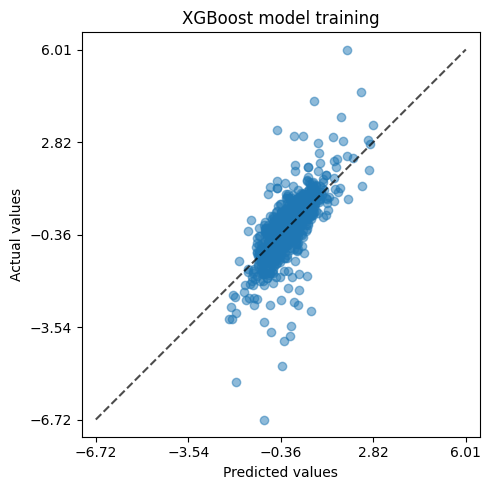

In [42]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_train_df.values.squeeze(),
    y_train_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model training")
plt.tight_layout()

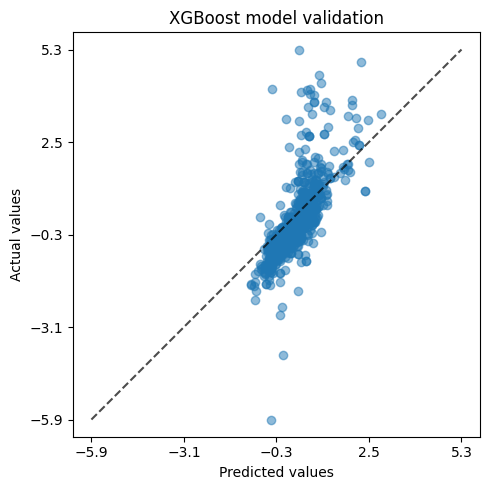

In [43]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test_df.values.squeeze(),
    y_test_pred,
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("XGBoost model validation")
plt.tight_layout()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

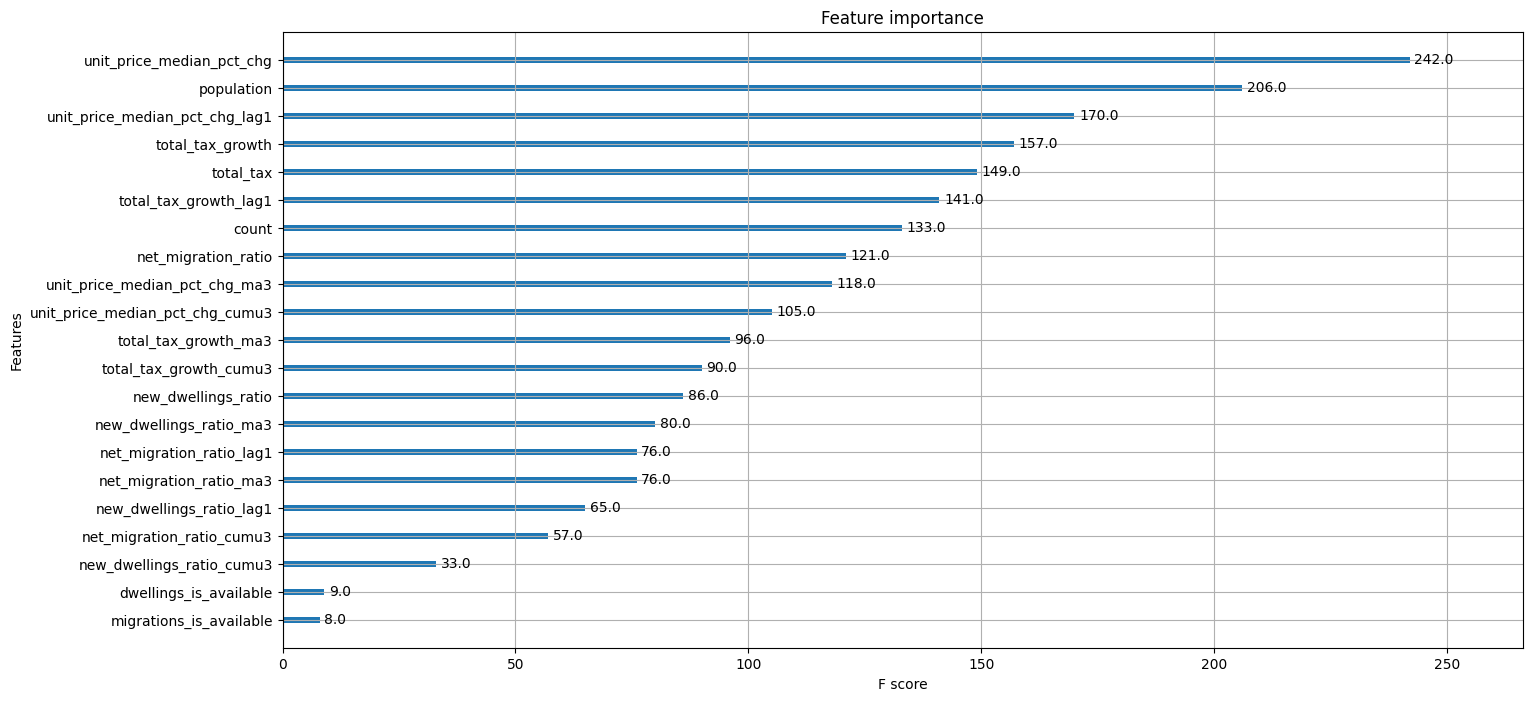

In [44]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_importance(xgb_regressor)